In [ ]:
#Import das Libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

In [ ]:
#carrega dados
colunas = ['id', 'pSist', 'pDiast', 'qPA', 'pulso', 'fResp', 'grav', 'class']
data = pd.read_csv('/content/env_vital_signals treino.txt', sep=',', names=colunas)

In [ ]:
#separa atributos e classes
data_attributes = data.drop(columns="class")
data_classes = data['class']

In [ ]:
#normaliza e balancea
normalizer = MinMaxScaler()
data_attributes_normalized = normalizer.fit_transform(data_attributes)

balancer = SMOTE()
data_attributes_balanced, data_classes_balanced = balancer.fit_resample(data_attributes_normalized, data_classes)

In [ ]:
#treinamento com Decision Tree
dt = DecisionTreeClassifier()
cv_results_dt = cross_validate(dt, data_attributes_balanced, data_classes_balanced, cv=10)

In [ ]:
#GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
#busca melhores hiperparâmetros
dt_grid = GridSearchCV(dt, param_grid_dt, refit=True, verbose=1)
dt_grid.fit(data_attributes_balanced, data_classes_balanced)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=1)

In [ ]:
# Treinar o modelo com os melhores parâmetros encontrados
dt_best_params = dt_grid.best_estimator_
dt_best_params.fit(data_attributes_balanced, data_classes_balanced)

DecisionTreeClassifier(max_depth=3)

In [ ]:
# Avaliar o desempenho do modelo
classes_predict_dt = dt_best_params.predict(data_attributes_normalized)
report_dt = classification_report(data_classes, classes_predict_dt)
print(report_dt)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       620
           2       1.00      1.00      1.00      2332
           3       1.00      1.00      1.00       989
           4       1.00      1.00      1.00        59

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [ ]:
# Salvar o modelo treinado
dump(dt_best_params, open("predict_decision_tree.pkl", "wb"))

In [ ]:
# Salvar o modelo treinado
dump(dt_grid, open("predict_decision_tree.pkl", "wb"))

In [ ]:
#carrega dados
test_data = pd.read_csv('/content/env_vital_signals teste.txt', sep=',', names=colunas)

# Separar atributos e classes da base de dados de teste
test_data_attributes = test_data.drop(columns="class")
test_data_classes = test_data['class']

# Normalizar os dados de teste usando o mesmo normalizador usado nos dados de treinamento
test_data_attributes_normalized = normalizer.transform(test_data_attributes)

# Avaliar o desempenho do modelo treinado na base de dados de teste
y_pred_test = dt_best_params.predict(test_data_attributes_normalized)
report_dt_test = classification_report(test_data_classes, y_pred_test)
print("Relatório de classificação na base de dados de teste:\n", report_dt_test)

Relatório de classificação na base de dados de teste:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       455
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00        15

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



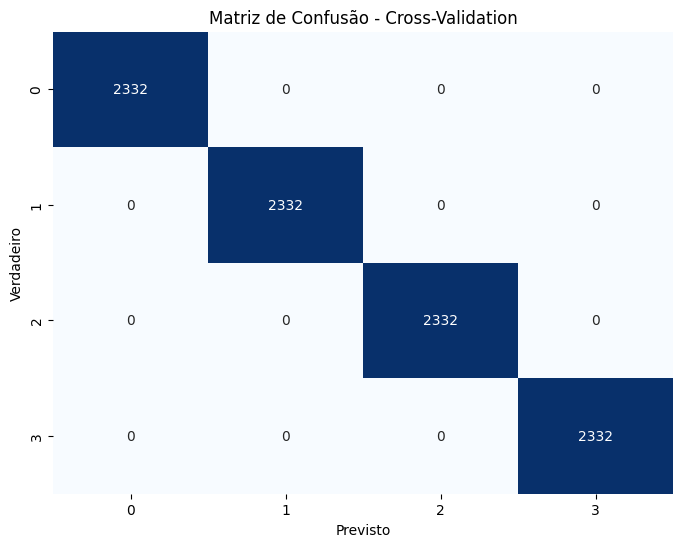

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Treinamento com Decision Tree usando cross-validation
dt_cv = DecisionTreeClassifier()
y_pred_cv = cross_val_predict(dt_cv, data_attributes_balanced, data_classes_balanced, cv=10)

# Calcular a matriz de confusão com os resultados do cross-validation
cm_cv = confusion_matrix(data_classes_balanced, y_pred_cv)

# Plotar a matriz de confusão do cross-validation usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão - Cross-Validation')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

In [ ]:
#Classificar o novo paciente
predict_file = load(open('predict_decision_tree.pkl', 'rb'))
#print(predict_file)
predict_pacient = predict_file.predict(test_data_attributes_normalized[[456]])
print(predict_pacient)

[2]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


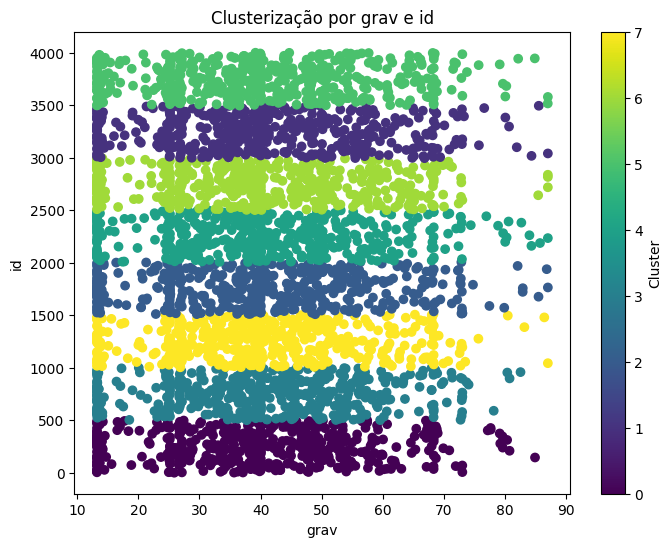

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecionar os atributos para clusterização
# colunas = ['id', 'pSist', 'pDiast', 'qPA', 'pulso', 'fResp', 'grav', 'class']
cluster_data = data[['grav', 'id']]

# Inicializar o modelo K-Means com o número desejado de clusters
kmeans = KMeans(n_clusters=8, random_state=4)

# Treinar o modelo de clusterização
clusters = kmeans.fit_predict(cluster_data)

# Adicionar as informações dos clusters aos dados
data_with_clusters = cluster_data.copy()
data_with_clusters['Cluster'] = clusters

# Visualizar os clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_with_clusters['grav'], data_with_clusters['id'], c=data_with_clusters['Cluster'], cmap='viridis')
plt.xlabel('grav')
plt.ylabel('id')
plt.title('Clusterização por grav e id')
plt.colorbar(label='Cluster')
plt.show()